In [1]:
import numpy as np          
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd    
import sklearn   

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# ТЗ: 
**Пересмотреть решение ДЗ №2. Выполнить то, что раньше было "по желанию". Сделать общие выводы**  
В ДЗ №2 требовалось решить классификационную задачу. Отметитим что уже было выполнено:  
 
- [x] Описать задачу словами
- [x] Прочитать данные
- [x] Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать.
- [x] Обработать пропущенные значения (или убедиться, что их нет)
- [x] Обработать категориальные признаки
- [x] Провести нормализацию (или объяснить, почему в вашем случае она не нужна)
- [x] Разбить данные на обучающую и тестовую выборки
- [x] Запустить классификатор ближайших соседей (попробовать разное их количество)
- [x] Вычислить ошибки на обучающей и тестовой выборках. Сделать выводы 
- [ ] По желанию: запустить другие классификаторы. Сравнить результаты
- [x] По желанию: как-то побороться с несбалансированностью классов (если она есть)
- [x] По желанию: исключить коррелированные переменные (объяснить зачем)
- [x] Сделать общие выводы
- [ ] Метод PCA работает? 

Следовательно на данный момент осталось исследовать другие классификаторы и метод PCA.  
В рамках данный работы будут рассмотрены следующие классификаторы: 

* **Random Forest**. С помощью  RF будет проведен отбор важных признаков. В конце мы проверим, как повлияло сокращение признаков. 
* **SVC**
* **Decision tree**
* **KNN**
* **MLP**
* **GBT**

# 1. Постановка задачи
**Задача**.  
Определить "престижность" квратиры по ее характеристикам.  
Предполагается что существует три уровня престижности: ниже среднего,cредняя и выше среднего.  
То есть перед нами задача классификации на 3 класса.  

**Данные**: В качетве обучающей выборки взят [набор данных о проданных квартрах](https://www.kaggle.com/gunhee/koreahousedata).</br>
Поскольку в самом датасете нет меток "престижности" в дальнейшем они будут искусственно сгенерированы на основе цен квартир на момент продажи. Соблюдены 2 уловия: разнородные признаки и наличие несбалансироыанных классов. 

# 2. Чтение и обработка данных

In [2]:
df = pd.read_csv('apartament_data.csv')
print(f'Число сэмлов = {df.shape[0]}')
print(f'Число признаков = {df.shape[1]}')
print(f'Типы признаков:')
[print('\tтип:', ttype, '\tчисло признаков:', num) 
    for ttype, num in zip(df.dtypes.value_counts().index, df.dtypes.value_counts())]
pass

Число сэмлов = 5891
Число признаков = 30
Типы признаков:
	тип: float64 	число признаков: 16
	тип: int64 	число признаков: 8
	тип: object 	число признаков: 6


#### Для удобства переименуем название признаков:

In [3]:
new_names = ['price', 'year_built', 'year_sold', 'month_sold', 'size', 'floor', 'hallway_type', 'heating_type',
              'apt_manage_type', 'n_ground_parking', 'n_basement_parking', 'time_to_bus', 
              'time_to_subway', 'n_apt', 'n_manager', 'n_elevators', 'subway_station', 'n_office', 'n_hospital',
              'n_dpartmentstore', 'n_mall', 'n_etc', 'n_park', 'n_elementary_school', 'n_middle_school',
              'n_high_school', 'n_university', 'n_facilities_in_apt','n_facilities', 'n_school']
rename_dict = {old_name: new_name for old_name, new_name in zip(df.columns, new_names)}
df = df.rename(columns=rename_dict)

**Удалим неинформативные признаки**  
неинформативные - признаки с высокой корреляцией или маленькой дисперсией  
Подробнее описано в ДЗ2

In [4]:
df = df.drop(['n_school'], axis=1)
df = df.drop(['n_facilities'], axis=1)
df = df.drop(['heating_type'], axis=1)
df = df.drop(['apt_manage_type'], axis=1)

**Бинаризуем категориальные признаки**

In [5]:
object_cols = df.select_dtypes("object").columns
for col in object_cols:
    df = pd.concat((df, pd.get_dummies(df[col])), axis=1)
    df = df.drop([col], axis=1)

**Преобразуем цену квартиры в ее "престижность"**  
Подробнее описано в ДЗ2

In [6]:
price = df.price
first_q = price.quantile(0.25)
third_q = price.quantile(0.75)
prestige = np.asarray(["middle"] * len(df))
prestige[list(df.price <= first_q)] = "low"
prestige[list(df.price > third_q)] = "hight"
df.insert(0, "prestige", pd.Series(prestige))
df['prestige'] = df['prestige'].astype('category')
df = df.drop(['price'], axis=1)
print("Доли квартир в общей выборке:")
df['prestige'].value_counts() 

Доли квартир в общей выборке:


middle    2953
low       1474
hight     1464
Name: prestige, dtype: int64

**Разбиение данных на обучающую и тестовую выборки**  

In [7]:
df_train, df_test = train_test_split(df,  test_size=0.2, random_state=42, stratify=df.prestige)
print(f"N_train = {len(df_train)}\nN_test = {len(df_test)}")

N_train = 4712
N_test = 1179


**Отделение меток и признаков + стандартизация**

In [8]:
X_train = df_train.drop(['prestige'], axis=1)
y_train = np.asarray([1] * len(df_train))
y_train[df_train.prestige == "low"] = 0
y_train[df_train.prestige == "hight"] = 2

X_test = df_test.drop(['prestige'], axis=1)
y_test = np.asarray([1] * len(df_test))
y_test[df_test.prestige == "low"] = 0
y_test[df_test.prestige == "hight"] = 2

mean = X_train.mean(axis = 0)
std = X_train.std(axis = 0)

X_train = (X_train - mean) / std
X_test =  (X_test  - mean) / std

# 3. Обучение классификаторов 
Подбор нетривиальных гиперпараметров моделей будет осущетсвляться с помощью GridSearchCV

In [114]:
error = {}

def scorer(estimator, X_test, y_test):
    return balanced_accuracy_score(y_test, estimator.predict(X_test))

## Random Forest

In [113]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = np.arange(1, 205, 50)
criterion = ["gini", "entropy"]
max_depth = np.arange(1, 16, 2)
forest = RandomForestClassifier()
grid = GridSearchCV(forest, cv=3, scoring=scorer,
                    param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth, 'criterion': criterion})
grid.fit(X_train, y_train)
print(f"GridCV error: {1 - grid.best_score_}")
print(f"Best_estimator: {grid.best_estimator_}")

GridCV error: 0.06122817157273308
Best_estimator: RandomForestClassifier(max_depth=15, n_estimators=51)


In [118]:
forest = RandomForestClassifier(max_depth=15, n_estimators=51).fit(X_train, y_train)
train_error = 1 - balanced_accuracy_score(y_train, forest.predict(X_train)) 
test_error = 1 - balanced_accuracy_score(y_test, forest.predict(X_test))
error["Random Forest"] = {"train": train_error, "test": test_error}
print(f"Random Forest test_error: {test_error}")

Random Forest test_error: 0.04075918019960356


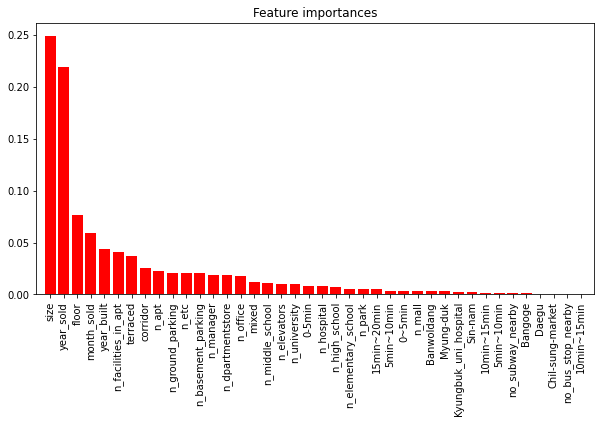

In [120]:
np.sum(forest.feature_importances_)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
    
d_first = 40
features_names = X_train.columns
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align = 'center', color = 'r')
plt.xticks(range(d_first), features_names[indices[:d_first]], rotation = 90)
plt.xlim([-1, d_first])
pass

Оставим топ 10 ризнаков с высокой значимостью 

In [121]:
X_train_clean = X_train[features_names[indices[:10]]]
X_test_clean = X_test[features_names[indices[:10]]]
X_train_clean.shape

(4712, 10)

In [122]:
forest = RandomForestClassifier(criterion='entropy', max_depth=13, n_estimators=101).fit(X_train, y_train)
train_error = 1 - balanced_accuracy_score(y_train, forest.predict(X_train)) 
test_error = 1 - balanced_accuracy_score(y_test, forest.predict(X_test))
error["Random Forest"] = {"train": train_error, "test": test_error}
print(f"Random Forest test_error: {test_error}")

Random Forest test_error: 0.04474579011819679


## KNN

In [125]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.arange(1, 15)
svc = KNeighborsClassifier(weights='distance', p=1, n_jobs=8)
grid = GridSearchCV(svc, cv=3, scoring=scorer,
                    param_grid = {'n_neighbors': n_neighbors})
grid.fit(X_train, y_train)
print(f"GridCV error: {1 - grid.best_score_}")
print(f"Best_estimator: {grid.best_estimator_}")

GridCV error: 0.08604358520057576
Best_estimator: KNeighborsClassifier(n_jobs=8, n_neighbors=4, p=1, weights='distance')


In [126]:
knn = KNeighborsClassifier(n_jobs=8, n_neighbors=4, p=1, weights='distance').fit(X_train, y_train)
train_error = 1 - balanced_accuracy_score(y_train, knn.predict(X_train)) 
test_error = 1 - balanced_accuracy_score(y_test, knn.predict(X_test))
error["KNN"] = {"train": train_error, "test": test_error}
print(f"KNN test_error: {test_error}")

KNN test_error: 0.06397803369419319


## SVC

In [127]:
from sklearn.svm import SVC

C = 10.**np.arange(-5, 5)
gamma_array = 10.**np.arange(-5, 5)
svc = SVC(gamma='auto', class_weight='balanced')
grid = GridSearchCV(svc, cv=3, scoring=scorer,
                    param_grid = {'C': C, 'gamma': gamma_array})
grid.fit(X_train, y_train)
print(f"GridCV error: {1 - grid.best_score_}")
print(f"Best_estimator: {grid.best_estimator_}")

GridCV error: 0.05606953904194434
Best_estimator: SVC(C=1000.0, class_weight='balanced', gamma=0.01)


In [129]:
svc = SVC(C=1000.0, class_weight='balanced', gamma=0.01).fit(X_train, y_train)
train_error = 1 - balanced_accuracy_score(y_train, svc.predict(X_train)) 
test_error = 1 - balanced_accuracy_score(y_test, svc.predict(X_test))
error["SVC"] = {"train": train_error, "test": test_error}
print(f"SVC test_error: {test_error}")

SVC test_error: 0.04242433021941938


## Decision tree

In [130]:
from sklearn.tree import DecisionTreeClassifier

criterion = ["gini", "entropy"]
max_depth = np.arange(1, 16, 2)
dtree = DecisionTreeClassifier()
grid = GridSearchCV(dtree, cv=3, scoring=scorer,
                    param_grid = {'max_depth': max_depth, 'criterion': criterion})
grid.fit(X_train, y_train)
print(f"GridCV error: {1 - grid.best_score_}")
print(f"Best_estimator: {grid.best_estimator_}")

GridCV error: 0.07240225714740045
Best_estimator: DecisionTreeClassifier(criterion='entropy', max_depth=9)


Decision tree test_error: 0.05324261445838674
Имена топовых признаков: terraced, size, year_sold


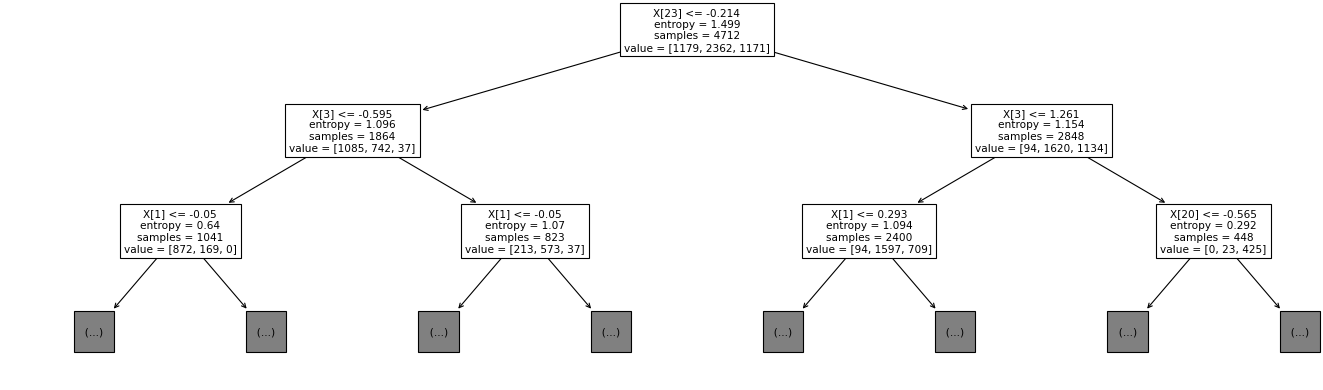

In [134]:
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=9).fit(X_train, y_train)
train_error = 1 - balanced_accuracy_score(y_train, dtree.predict(X_train)) 
test_error = 1 - balanced_accuracy_score(y_test, dtree.predict(X_test))
error["Decision tree"] = {"train": train_error, "test": test_error}
print(f"Decision tree test_error: {test_error}")

from matplotlib.pyplot import figure
from sklearn import tree
figure(figsize=(20, 6), dpi=80)
_= tree.plot_tree(dtree, max_depth=2)
print(f"Имена топовых признаков: {features_names[23]}, {features_names[3]}, {features_names[1]}")

## MLP 

Поскольку оптимальное число слоев подобрано в  ДЗ 6,   
то здесь поэкспеременитируем с числом нейронов на очищенных данных

In [135]:
from sklearn.neural_network import MLPClassifier

hidden_layer_sizes = [1, 30, 2]
mlp = MLPClassifier(max_iter=1000, solver="adam", activation='relu')
grid = GridSearchCV(mlp, cv=3, scoring=scorer,
            param_grid = {'hidden_layer_sizes': hidden_layer_sizes})
grid.fit(X_train, y_train)
print(f"GridCV error: {1 - grid.best_score_}")
print(f"Best_estimator: {grid.best_estimator_}")

GridCV error: 0.062083778415476076
Best_estimator: MLPClassifier(hidden_layer_sizes=30, max_iter=1000)


In [136]:
mlp = MLPClassifier(hidden_layer_sizes=(30,), max_iter=1000).fit(X_train, y_train)
train_error = 1 - balanced_accuracy_score(y_train, mlp.predict(X_train)) 
test_error = 1 - balanced_accuracy_score(y_test, mlp.predict(X_test))
error["MLP"] = {"train": train_error, "test": test_error}
print(f"MLPClassifier test_error: {test_error}")

MLPClassifier test_error: 0.03910760936488733


## GBT

In [137]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = np.arange(10, 200, 20)
gbt = GradientBoostingClassifier()
grid = GridSearchCV(gbt, cv=3, scoring=scorer,
            param_grid = {'n_estimators': n_estimators})
grid.fit(X_train, y_train)
print(f"GridCV error: {1 - grid.best_score_}")
print(f"Best_estimator: {grid.best_estimator_}")

GridCV error: 0.054985165742345354
Best_estimator: GradientBoostingClassifier(n_estimators=170)


In [138]:
gbt = GradientBoostingClassifier(n_estimators=170).fit(X_train, y_train)
train_error = 1 - balanced_accuracy_score(y_train, gbt.predict(X_train)) 
test_error = 1 - balanced_accuracy_score(y_test, gbt.predict(X_test))
error["GBT"] = {"train": train_error, "test": test_error}
print(f"GBT test_error: {test_error}")

GBT test_error: 0.03680915773456783


# 4.1 Обучение на очищенных данных (RandomForest)

In [158]:
forest = RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=51).fit(X_train_clean, y_train)
train_error = 1 - balanced_accuracy_score(y_train, forest.predict(X_train_clean)) 
test_error = 1 - balanced_accuracy_score(y_test, forest.predict(X_test_clean))
error["Random\nForest"]["clean"] = {"train": train_error, "test": test_error}

knn = KNeighborsClassifier(n_jobs=8, n_neighbors=4, p=1, weights='distance').fit(X_train_clean, y_train)
train_error = 1 - balanced_accuracy_score(y_train, knn.predict(X_train_clean)) 
test_error = 1 - balanced_accuracy_score(y_test, knn.predict(X_test_clean))
error["KNN"]["clean"] = {"train": train_error, "test": test_error}

svc = SVC(C=1000.0, class_weight='balanced', gamma=0.01).fit(X_train_clean, y_train)
train_error = 1 - balanced_accuracy_score(y_train, svc.predict(X_train_clean)) 
test_error = 1 - balanced_accuracy_score(y_test, svc.predict(X_test_clean))
error["SVC"]["clean"] = {"train": train_error, "test": test_error}

dtree = DecisionTreeClassifier(criterion='entropy', max_depth=9).fit(X_train_clean, y_train)
train_error = 1 - balanced_accuracy_score(y_train, dtree.predict(X_train_clean)) 
test_error = 1 - balanced_accuracy_score(y_test, dtree.predict(X_test_clean))
error["Decision tree"]["clean"]= {"train": train_error, "test": test_error}

mlp = MLPClassifier(hidden_layer_sizes=(30,), max_iter=1000).fit(X_train_clean, y_train)
train_error = 1 - balanced_accuracy_score(y_train, mlp.predict(X_train_clean)) 
test_error = 1 - balanced_accuracy_score(y_test, mlp.predict(X_test_clean))
error["MLP"]["clean"] = {"train": train_error, "test": test_error}

gbt = GradientBoostingClassifier(n_estimators=170).fit(X_train_clean, y_train)
train_error = 1 - balanced_accuracy_score(y_train, gbt.predict(X_train_clean)) 
test_error = 1 - balanced_accuracy_score(y_test, gbt.predict(X_test_clean))
error["GBT"]["clean"] = {"train": train_error, "test": test_error}

# 4.2 Снижение размерности методом PCA

In [10]:
from sklearn.decomposition import PCA

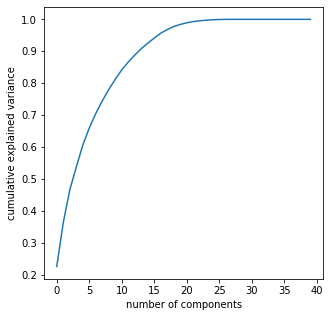

In [141]:
n_samples, n_features = X_train.shape
n_components = min(n_samples, n_features) # n_features = 42
pca = PCA(n_components)
pca.fit(X_train)


plt.rcParams["figure.figsize"] = (5,5)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

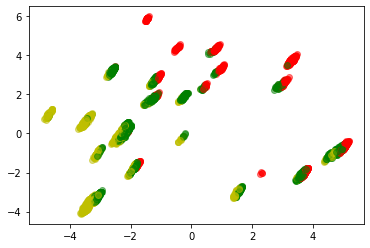

In [29]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_2d = pca.transform(X_train)
color = ['r', 'g', 'y']

for point, label in zip(X_train_2d, y_train):
    plt.scatter(point[0], point[1], c=color[label], alpha=0.5)
plt.show()

Видно, что уже в ~10 новых признаках содержится 80% исходной информации и ~100% в 20 признаках.  
Спроецируем исходные признаки в 20-мерное пространство 

In [143]:
pca = PCA(n_components=20)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

forest = RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=51).fit(X_train_pca, y_train)
train_error = 1 - balanced_accuracy_score(y_train, forest.predict(X_train_pca)) 
test_error = 1 - balanced_accuracy_score(y_test, forest.predict(X_test_pca))
error["Random Forest"]["pca"] = {"train": train_error, "test": test_error}

knn = KNeighborsClassifier(n_jobs=8, n_neighbors=4, p=1, weights='distance').fit(X_train_pca, y_train)
train_error = 1 - balanced_accuracy_score(y_train, knn.predict(X_train_pca)) 
test_error = 1 - balanced_accuracy_score(y_test, knn.predict(X_test_pca))
error["KNN"]["pca"] = {"train": train_error, "test": test_error}

svc = SVC(C=1000.0, class_weight='balanced', gamma=0.01).fit(X_train_pca, y_train)
train_error = 1 - balanced_accuracy_score(y_train, svc.predict(X_train_pca)) 
test_error = 1 - balanced_accuracy_score(y_test, svc.predict(X_test_pca))
error["SVC"]["pca"] = {"train": train_error, "test": test_error}

dtree = DecisionTreeClassifier(criterion='entropy', max_depth=9).fit(X_train_pca, y_train)
train_error = 1 - balanced_accuracy_score(y_train, dtree.predict(X_train_pca)) 
test_error = 1 - balanced_accuracy_score(y_test, dtree.predict(X_test_pca))
error["Decision tree"]["pca"]= {"train": train_error, "test": test_error}

mlp = MLPClassifier(hidden_layer_sizes=(30,), max_iter=1000).fit(X_train_pca, y_train)
train_error = 1 - balanced_accuracy_score(y_train, mlp.predict(X_train_pca)) 
test_error = 1 - balanced_accuracy_score(y_test, mlp.predict(X_test_pca))
error["MLP"]["pca"] = {"train": train_error, "test": test_error}

gbt = GradientBoostingClassifier(n_estimators=150).fit(X_train_pca, y_train)
train_error = 1 - balanced_accuracy_score(y_train, gbt.predict(X_train_pca)) 
test_error = 1 - balanced_accuracy_score(y_test, gbt.predict(X_test_pca))
error["GBT"]["pca"] = {"train": train_error, "test": test_error}

# 5. Сравнение классификаторов и выводы

In [144]:
error['Random\nForest'] = error.pop('Random Forest')
error['Decision\ntree'] = error.pop('Decision tree')
error = dict(sorted(error.items(), key=lambda item: item[1]['test']))

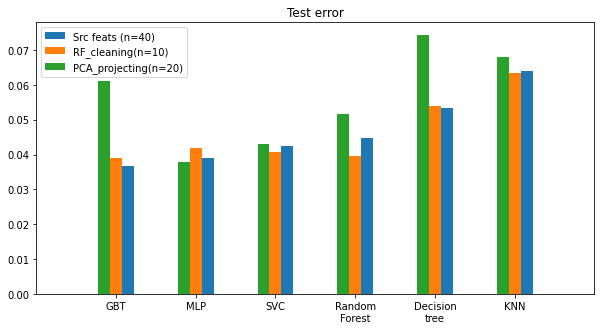

In [159]:
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Test error")
plt.bar(np.arange(len(error))+0.15, [v['test'] for v in error.values()], align = 'center', width=0.15, label=f"Src feats (n={X_train.shape[1]})")
plt.bar(np.arange(len(error)), [v["clean"]['test'] for v in error.values()], align = 'center',width=0.15, label=f"RF_cleaning(n={X_train_clean.shape[1]})")
plt.bar(np.arange(len(error))-0.15, [v["pca"]['test'] for v in error.values()], align = 'center', width=0.15, label=f"PCA_projecting(n={X_train_pca.shape[1]})")
plt.xticks(range(len(error)), error.keys())
plt.xlim([-1, len(error)])
plt.legend()
pass

**Выводы:** 
* Как показал анализ информативности признаков на основе уменьшения энтропии **Random Forest** наиболее полезными для классификации являются признаки - размер квартиры, год продажи и этаж, месяц продажи и год постройки. 
* Если посмотреть на анализ признаков только **Decision tree** решений, то лучшими характеристиками оказываются:  terraced - категориальный признак, отвечающий за тип "подъезда", size - размер квартиры и year_sold - год продажи. * Мы видим отличие топовых признаков по мнению одного дерева решений и случайного леса. И в случае случайного лека признаки кажутся более логичными и полезными для качественно определения престижности апартментов. 

* Выбор числа компонент для метода PCA (МГК) показал, что примерно 100% исходной информации может быть описано новыми 20 признаками.

**Рассмотрим график Test Error:**
* Наиболее эффективными оказались GBT, MLP, SVC и Random Forest алгоритмы классификации
* Худщим оказался KNN -> описательныее признаки плохо кластеризуются по классам
* Видим, что классификация на основе главных компонент показывает высокую ошибку (относительно других вариантов признаковых описаний) на моделях использующих "условные" правила - GBT, RF, DT -> Используя PCA мы уменьшаем количество признаков и избавляемся от коллинеарных функций (все коллинеарные функции будут объединены в один компонент PCA) -> не реккомендуется совмешать PCA и методы ML, основанные на решающих правилах. Однако на более хитрых моделях PCA признаки работают не хуже остальных. 
* Удаление лишних признаков с помощью RF cleaning в целом не ухудшило ошибку на тестовой выборке для всех моделей -> это универсальный снижательн размерности (в отличии от PCA). Удалось сократить число признаков в 40 до 10 и не потерять в точности
* В целом все алгоритмы показали хорошую точность -> Выполнять классификацию на этих данных - простая задача априори 